# <div style=" text-align: center; font-weight: bold">Phase 04: Modelling</div>



In the `Price` column of the dataframe, we can see that there is many value is `Thỏa thuận`, In this part, we will model to predict the price of real estates in type `Căn hộ chung cư` that have price `Thỏa thuận` based on its attribute.

## **Import necessary Python modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# !pip install joblib
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### **Read the data from file**
First, read the clean data that we cleaned before to a dataframe.

In [2]:
real_estate_for_sale_df = pd.read_csv('../Data/cleaned_real_estate_for_sale.csv', encoding='utf-8')

### **Preprocessing data**
- First, we have to extract the real estate that in type `Căn hộ chung cư`


In [3]:
apartment_df = real_estate_for_sale_df[real_estate_for_sale_df['Type'] == 'Căn hộ chung cư']

#### **Remove features that is not necessary for the model:**
- We can see that, the column `Project` have many seperated values, also the `Posting date` column doesn't much meaning, so we will drop them.

In [4]:
# Drop unncessary columns
apartment_df = apartment_df.copy()
apartment_df.drop(columns= ['Project', 'Posting date'], axis= 1, inplace= True)

Beside that, as we discuss before, for `Căn hộ chung cư`, the column `Floor` `Furniture` and `Legal` does not affect a lot to the price, so we also drop them

In [5]:
apartment_df.drop(columns= [ 'Floor(Tầng)', 'Furniture', 'Legal'], axis= 1, inplace= True)

#### **Convert all the non-numeric columns into numeric columns:**
With the columnn `District`, the data is in nominal data type, so one possible way to converr this column into numeric column is using `One hot encoding` method

In [6]:
# Perform one hot encoding for District
apartment_df = pd.get_dummies(apartment_df, columns=['District'])
apartment_df.drop(columns=['Type'], inplace= True)

Now, with the purpose of predict the price of real estate that have the price is `Thỏa thuận` (currently is `NaN`), we will seperate the dataframe into two part, one that price this  `Thỏa thuận` and all the others.

In [7]:
# Extract price the is not Thỏa thuận for the traning model.
processed_apartment_df = apartment_df[apartment_df['Price(VNĐ)'].notna()]
data_to_predict_df = apartment_df[apartment_df['Price(VNĐ)'].isna()]

Also, with the `Price` column, the unit of it currently is `VNĐ`, but for the better performance of the model, we can reduce the price by convert it into `Triệu` 

In [8]:
# Set new unit for Price to get more effecienct in the train process.
processed_apartment_df .loc[:,'Price(VNĐ)'] = processed_apartment_df.loc[:,'Price(VNĐ)'] / 1000000
processed_apartment_df.rename(columns= {'Price(VNĐ)' : 'Price (Million)'}, inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14860\1906477762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_apartment_df.rename(columns= {'Price(VNĐ)' : 'Price (Million)'}, inplace=True)


Now we have `processed_apartment_df`, let's start to build a model

## **Build model**

In this section, we will try to build and train in these model:
- **Linear Regression**
- **Ridge Regression**
- **Lasso Regression**
- **ElasticNet Regression**
- **Decision Tree Regression**
- **Random Forest Regression**

### **Model selection:**

First, we will prepare the data for the linear regression model. First, we take the `Y` data frame is the `Price`, and `X` is all the attributes `Area`, `Bedroom`, `Toilet`, `District` 

In [9]:
# Define X and y features.
X = processed_apartment_df.drop(columns=['Price (Million)'])
y = processed_apartment_df['Price (Million)']

# Split the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, let's consider some models that we could use here. After some research, I can findout some model below may be suitable for our regression problem


In [10]:
# Prepare models
model_linear = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()
model_elastic_net = ElasticNet()
model_dtree = DecisionTreeRegressor()
model_rforest = RandomForestRegressor()

But among them, which is the best one? To find that, we have to do a validation step to find out which one will do the best for out data. In this case, we will use `K Fold Cross Validation` to find the best model for our data. We can easily see this is a good method because it can make sure that all the values can be trained and test, from that, the accurancy and the performance of the model can be validate in the best way.

In [11]:
# Define score matrix
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Compare models
model_linear_score = cross_validate(model_linear, X, y, cv = 7, scoring = scoring_metrics)
model_ridge_score = cross_validate(model_ridge,  X, y, cv = 7, scoring = scoring_metrics)
model_lasso_score = cross_validate(model_lasso,  X, y, cv = 7, scoring = scoring_metrics)
model_elastic_net_score = cross_validate(model_elastic_net, X, y, cv = 7, scoring = scoring_metrics)
model_dtree_score = cross_validate(model_dtree,  X, y, cv = 7, scoring = scoring_metrics)
model_rforest_score = cross_validate(model_rforest, X, y, cv = 7, scoring = scoring_metrics)

In [12]:
# Comparing our models
model_test_results = pd.DataFrame(columns=['model_linear_score', 'model_ridge_score', 'model_lasso_score', 'model_elastic_net_score', 'model_dtree_score', 'model_rforest_score'],
                                  index=model_dtree_score.keys())

model_test_results['model_linear_score'] = pd.DataFrame(model_linear_score).abs().mean().to_numpy().round(3)
model_test_results['model_ridge_score'] = pd.DataFrame(model_ridge_score).abs().mean().to_numpy().round(3)
model_test_results['model_lasso_score'] = pd.DataFrame(model_lasso_score).abs().mean().to_numpy().round(3)
model_test_results['model_elastic_net_score'] = pd.DataFrame(model_elastic_net_score).abs().mean().to_numpy().round(3)
model_test_results['model_dtree_score'] = pd.DataFrame(model_dtree_score).abs().mean().to_numpy().round(3)
model_test_results['model_rforest_score'] = pd.DataFrame(model_rforest_score).abs().mean().to_numpy().round(3)

model_test_results


,model_linear_score,model_ridge_score,model_lasso_score,model_elastic_net_score,model_dtree_score,model_rforest_score
fit_time,0.025,0.012,0.284,0.062,0.051,2.748
score_time,0.005,0.004,0.004,0.004,0.005,0.041
test_neg_mean_squared_error,6771212.424,6770982.712,6771839.149,8815554.440,6231501.055,5069163.559
test_neg_mean_absolute_error,1566.103,1565.688,1564.715,1757.392,1126.707,1070.746
test_r2,0.659,0.659,0.659,0.557,0.684,0.747


- Among model, we can see that `Random Forest` give me the best `R2 score` with over 0.7, but also take the most time (upto 2 seconds to train and 0.032 seconds to test).

- All the error of `Elastic net model` are higher than the overall, seems that this will be this worst performance among all the model

- But in a broader view, also for my curiosity, I think we will use all of them to build the model.

Before that, we want to tune and get the best hyperparameter for each model. For this purpose, we will use `GridSearchCV` to do this task
Let's make some define for the model.

In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(random_state= 42)
}

param_grids = {
    'Linear Regression': {'fit_intercept': [True, False],},
    'Ridge Regression': {'alpha': [0.1, 0.5, 0.75, 1, 10]},
    'Lasso Regression': {'alpha': [0.1, 0.5, 0.75, 1, 10]},
    'ElasticNet Regression': {'alpha': [0.1, 0.5, 1, 10],
                               'l1_ratio': [0.25, 0.5, 0.75, 1]},
    'Decision Tree Regression': {'max_depth': [None, 5, 10, 15],
                                 'min_samples_split': [2, 5, 10],
                                 'min_samples_leaf': [1, 2, 4],},
    'Random Forest Regression': {'n_estimators': [10, 50, 100],
                                  'max_depth': [None, 5, 10, 15],
                                  'min_samples_split': [2, 5, 10],
                                  'min_samples_leaf': [1, 2, 4]}
}

Now. let's find out the best hyperparameter for each model

In [14]:

best_params_dict = {}

for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    best_params_dict[model_name] = {
        'best_score':  grid_search.best_score_,
        'best_params':  grid_search.best_params_
    }

best_params_dict

{'Linear Regression': {'best_score': -6785531.5127693415,
  'best_params': {'fit_intercept': True}},
 'Ridge Regression': {'best_score': -6785280.419091743,
  'best_params': {'alpha': 1}},
 'Lasso Regression': {'best_score': -6785544.8837822005,
  'best_params': {'alpha': 0.1}},
 'ElasticNet Regression': {'best_score': -6785544.8837822005,
  'best_params': {'alpha': 0.1, 'l1_ratio': 1}},
 'Decision Tree Regression': {'best_score': -5365539.617994848,
  'best_params': {'max_depth': None,
   'min_samples_leaf': 4,
   'min_samples_split': 5}},
 'Random Forest Regression': {'best_score': -4975788.22868046,
  'best_params': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 50}}}

With the best hyperparameters, now we start to build models.

For each model, we will run the model in train_set and test_set, for each set, we will find scores bellow to validate the effeciency of the model:
- `MAE`: Mean Absolute Error
- `MSE` : Mean Square Error
- `R2 score` : R-Square score

Let's make some function define:

In [15]:
def find_scores(y, y_pred):
    mae_score = mean_absolute_error(y, y_pred).round(5)
    mse_score = mean_squared_error(y, y_pred).round(5)
    r2_value = r2_score(y, y_pred).round(5)

    return mae_score, mse_score, r2_value

def scatter_plot(y_true, y_pred,  title):
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.scatter(y_true, y_pred,alpha= 0.5)
    plt.title(title)
    plt.xlabel('Actual prices')
    plt.ylabel('Predicted prices')
    
    sns.despine()
    fig = plt.gcf()
    fig.set_facecolor('#ffe6cc')
    plt.show()


### **1. Multiple Linear Regression:**

In [16]:
best_params = best_params_dict['Linear Regression']['best_params']
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

MAE Train: 1551.13862
MSE Train: 6687399.37762
R2 score: 0.66562


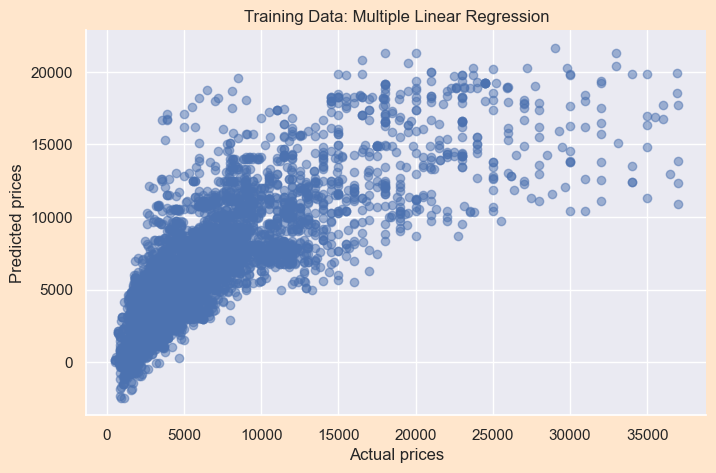

In [17]:
y_pred_train = linear_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Training Data: Multiple Linear Regression")

MAE Test: 1584.71726
MSE Test: 6870383.10517
R2 score: 0.6504


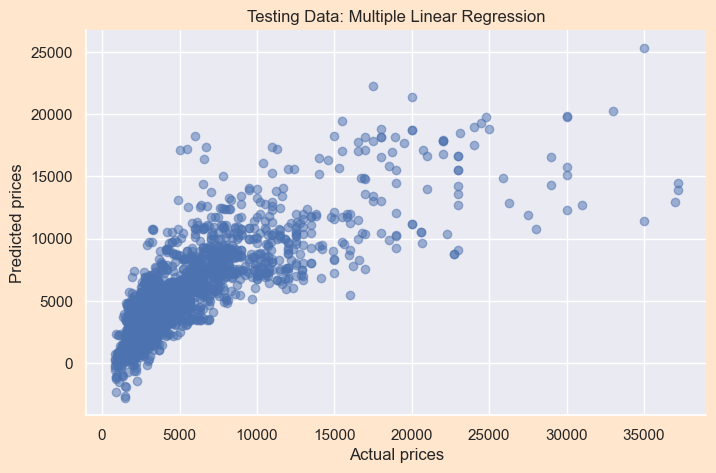

In [18]:
y_pred_test = linear_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Test: {mae_score}')
print(f'MSE Test: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_test, y_pred_test, title="Testing Data: Multiple Linear Regression")

### **Ridge Regression:**

In [19]:

best_params = best_params_dict['Ridge Regression']['best_params']

ridge_model = Ridge(**best_params)
ridge_model.fit(X_train, y_train)

Ridge(alpha=1)

MAE Train: 1550.76545
MSE Train: 6687445.04624
R2 score: 0.66561


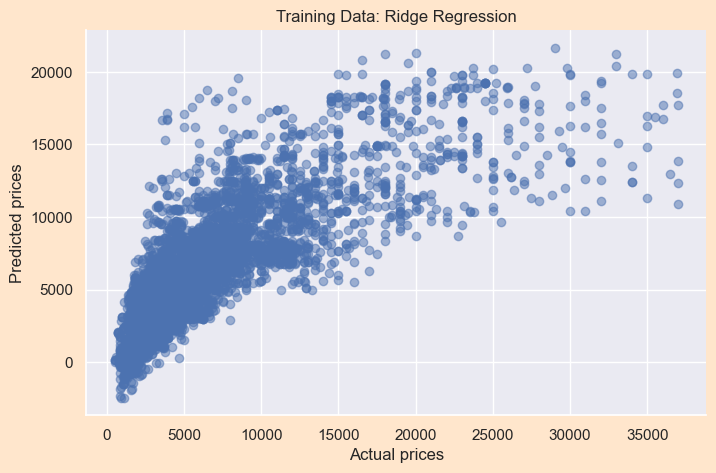

In [20]:
y_pred_train = ridge_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train.values, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Training Data: Ridge Regression")

MAE Train: 1584.22742
MSE Train: 6868620.6755
R2 score: 0.65049


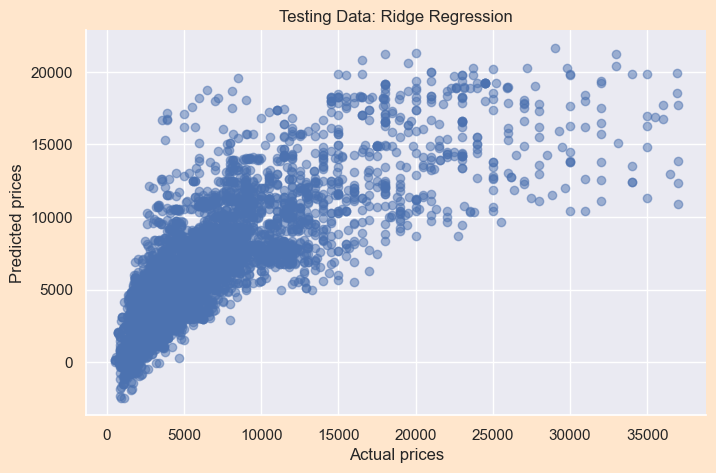

In [21]:
y_pred_test = ridge_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Testing Data: Ridge Regression")

### **Lasso regression:**

In [22]:

best_params = best_params_dict['Lasso Regression']['best_params']

lasso_model = Lasso(**best_params)
lasso_model.fit(X_train, y_train)


Lasso(alpha=0.1)

MAE Train: 1550.9806
MSE Train: 6687422.93079
R2 score: 0.66562


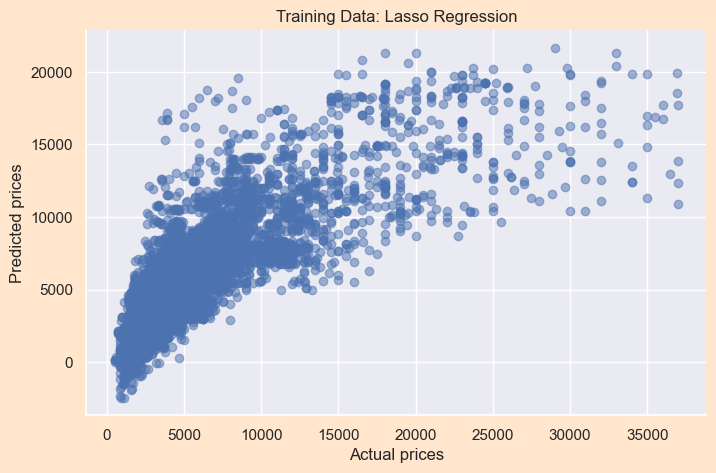

In [23]:
y_pred_train = lasso_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train.values, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Training Data: Lasso Regression")

MAE Test: 1584.51029
MSE Test: 6870026.03486
R2 score: 0.65042


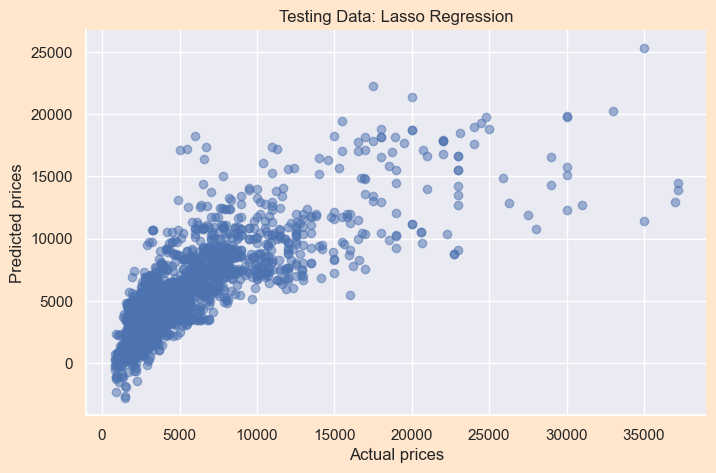

In [24]:
y_pred_test = lasso_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Test: {mae_score}')
print(f'MSE Test: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_test, y_pred_test, title="Testing Data: Lasso Regression")

### **ElasticNet Regression**

In [25]:

best_params = best_params_dict['ElasticNet Regression']['best_params']
elastic_net_model = ElasticNet(**best_params)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=1)

MAE Train: 1550.9806
MSE Train: 6687422.93079
R2 score: 0.66562


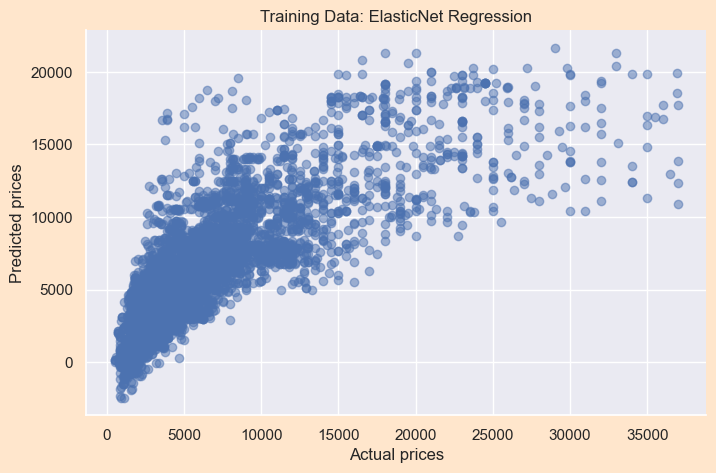

In [26]:
y_pred_train = elastic_net_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train.values, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Training Data: ElasticNet Regression")

MAE Test: 1584.51029
MSE Test: 6870026.03486
R2 score: 0.65042


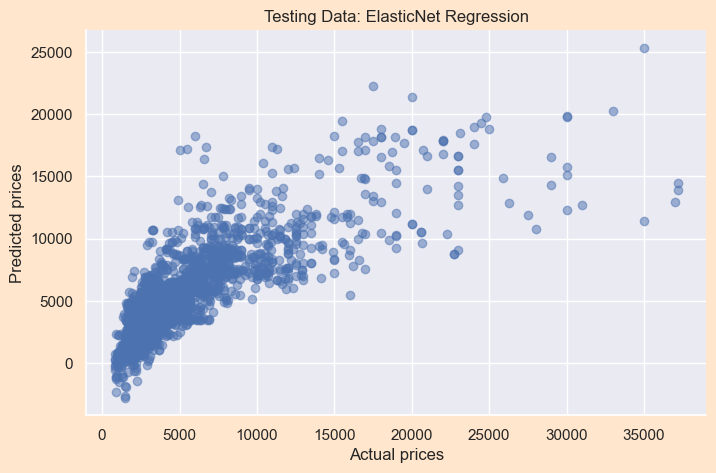

In [27]:
y_pred_test = elastic_net_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Test: {mae_score}')
print(f'MSE Test: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_test, y_pred_test, title="Testing Data: ElasticNet Regression")

### **Decision Tree Regression**

In [28]:
best_params = best_params_dict['Decision Tree Regression']['best_params']

decision_tree_model = DecisionTreeRegressor(**best_params)
decision_tree_model.fit(X_train, y_train)


DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=5)

MAE Train: 907.8737
MSE Train: 3229649.8167
R2 score: 0.83851


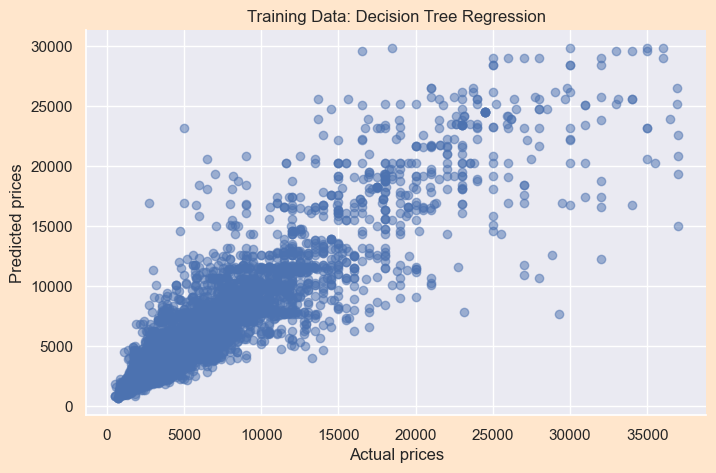

In [29]:
y_pred_train = decision_tree_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train.values, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_train, y_pred_train, title="Training Data: Decision Tree Regression")

MAE Test: 1093.37171
MSE Test: 4948233.68082
R2 score: 0.74821


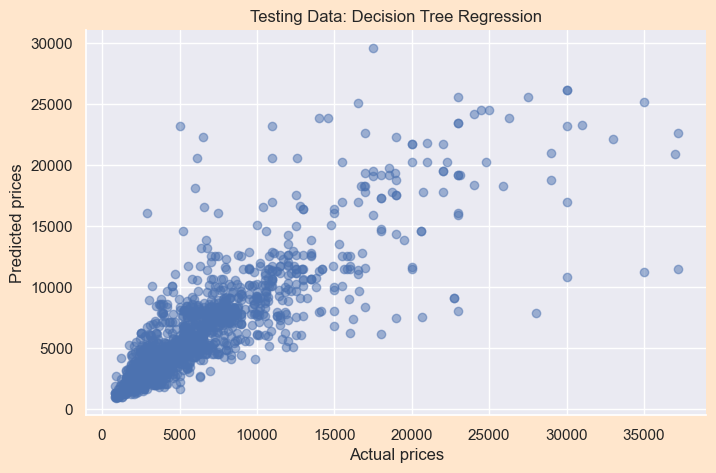

In [30]:
y_pred_test = decision_tree_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Test: {mae_score}')
print(f'MSE Test: {mse_score}')
print(f'R2 score: {r2_value}')

scatter_plot(y_test, y_pred_test, title="Testing Data: Decision Tree Regression")

### **Random Forest Regression**

In [31]:

best_params = best_params_dict['Random Forest Regression']['best_params']

random_forest_model = RandomForestRegressor(**best_params, random_state=42)
random_forest_model.fit(X_train, y_train)


RandomForestRegressor(min_samples_split=10, n_estimators=50, random_state=42)

In [32]:
y_pred_train = random_forest_model.predict(X_train)
mae_score, mse_score, r2_value = find_scores(y_train.values, y_pred_train)

print(f'MAE Train: {mae_score}')
print(f'MSE Train: {mse_score}')
print(f'R2 score: {r2_value}')


MAE Train: 853.16739
MSE Train: 2791138.43011
R2 score: 0.86044


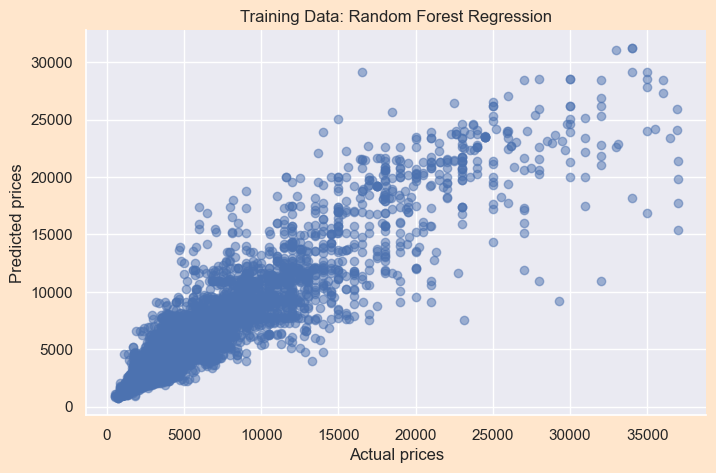

In [33]:
scatter_plot(y_train, y_pred_train, title="Training Data: Random Forest Regression")

In [34]:
y_pred_test = random_forest_model.predict(X_test)
mae_score, mse_score, r2_value = find_scores(y_test.values, y_pred_test)

print(f'MAE Test: {mae_score}')
print(f'MSE Test: {mse_score}')
print(f'R2 score: {r2_value}')

MAE Test: 1057.01881
MSE Test: 4506812.3974
R2 score: 0.77067


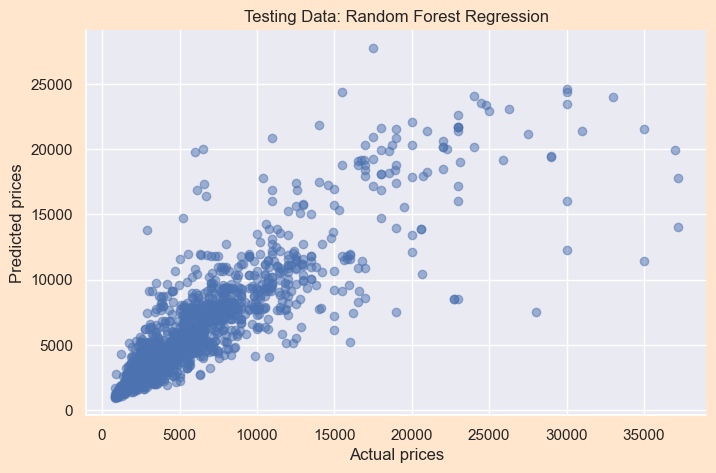

In [35]:
scatter_plot(y_test, y_pred_test, title="Testing Data: Random Forest Regression")

**Overall:**
- With `Multiple Linear Regression`, `Ridge`, `Lasso`, `ElasticNet`, the train and test result are nearly the same (in around 0.65), also the `MAE`, `MSE` doesn't change a lot between the train set and test set. Here, we can easily see the trend of the data the was predicted, which tend to become higher in the lower price range, and with the higher range, the precited value become just more lower than the actual one.

- About `Decision Tree` and `Random Forest`, the result is quite good in the train set (upto 0.83 and 0.86), but in the test set, the result just in 0.74 and 0.77, also. the `MAE` and `MSE` raise a lot (nearly double for `MSE` of `Random Forest`), so we can consider there might be overfifting here.

- By the plot, we can see that all models doesn't work for price that is so high (over 25000). In this range of Price, the difference between actual prices and predicted prices can be easily observed.

### Use model to predict the price:
In this section, we want to use the model that have the most performace. So, we will use `Decison Tree Regression` to predict the price of apartment with price is `Thoa thuan`:

In [36]:
# Extract the infomation to predict
predict_data = data_to_predict_df.drop(columns=['Price(VNĐ)'])

In [37]:
# Predict the price base on the given information
y_pred = decision_tree_model.predict(predict_data)

In [38]:
data_to_predict_df.loc[:,'Price(Million)'] = y_pred
data_to_predict_df.drop(columns= 'Price(VNĐ)', inplace= True)
data_to_predict_df

C:\Users\DELL\AppData\Local\Temp\ipykernel_14860\3951568062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_predict_df.loc[:,'Price(Million)'] = y_pred
C:\Users\DELL\AppData\Local\Temp\ipykernel_14860\3951568062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_predict_df.drop(columns= 'Price(VNĐ)', inplace= True)


,Area(m2),Bedroom(Phòng),Toilet(Phòng),District_1,District_10,District_11,District_12,District_2,District_3,District_4,...,District_Bình Thạnh,District_Bình Tân,District_Gò Vấp,District_Hóc Môn,District_Nhà Bè,District_Phú Nhuận,District_Thủ Đức,District_Tân Bình,District_Tân Phú,Price(Million)
16,72.00,2.0,2.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,5324.583333
45,79.11,2.0,2.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,6253.333333
49,78.00,2.0,2.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,4558.000000
162,99.00,3.0,3.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,13600.000000
181,108.00,3.0,2.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,10280.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43617,100.00,3.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,5758.312500
43696,56.00,2.0,1.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1823.333333
43706,65.00,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2146.000000
43719,26.00,1.0,1.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1138.571429


###  Deploy the model

Also, we will use `Decision Tree` model to deploy our data. Here, we will use `Streamlit` in this task

In [39]:

joblib.dump(decision_tree_model, "../Deploy/decision_tree_model_for_sale.sav")

['../Deploy/decision_tree_model_for_sale.sav']